In [146]:
import pandas as pd
import numpy as np
from Functions import Cleaning_Functions
from sklearn import model_selection, linear_model, neighbors, preprocessing, metrics, ensemble

fun = Cleaning_Functions()

clean = pd.read_csv("../data/clean.csv")
#clean  = clean.drop("continent", axis =1)
clean  = clean.drop("continent", axis =1)
clean.YEAR = clean.YEAR.astype('category')

In [121]:
def standarize_data(df):
        """
        Input: a dataset
        action: returns numeric column values scaled by mean and standard deviation
        """
        numeric_data = df.select_dtypes(include=['float64', 'int64'])
        for i in numeric_data.columns:
            df[i] = (df[i] - df[i].mean())/df[i].std()
        return df

In [147]:
market_data = fun.delete_id_columns(clean) #1
market_data, pred_market = fun.drop_response_rows_with_NAs(market_data, "Market_Orientation", "PPI_Likelihood") #2
market_data = fun.replace_NAN_with_na(market_data) #3
market_data = fun.entry_to_lowercase(market_data) #4
market_data = fun.remove_underscores_spaces(market_data) #5
market_data = fun.convert_to_categorical(market_data) #6
market_data = fun.impute_data(market_data)
market_data = standarize_data(market_data)


In [123]:
pred_market

,crop_count,crop_name_1,crop_harvest_1,crop_intercrop_1,YEAR,Country,HHsizemembers,HHsizeMAE,HouseholdType,Head_EducationLevel,...,livestock_prodsales_USD_PPP_pHH_Yr,value_livestock_production_USD_PPP_pHH_Yr,value_livestock_prod_consumed_USD_PPP_pHH_Yr,Market_Orientation,Livestock_Orientation,Food_Availability_kCal_MAE_day,Food_Self_Sufficiency_kCal_MAE_day,NrofMonthsWildFoodCons,Gender_MaleControl,Gender_FemaleControl
3,NaN,cowpea,NaN,NaN,2015,Tanzania,11,9.33,together,primary,...,0.0,0.0,0.0,NaN,NaN,257.234727,257.234727,0,NaN,NaN
15,NaN,groundnut,NaN,NaN,2015,Tanzania,4,2.86,together,illiterate,...,0.0,0.0,0.0,NaN,NaN,296.878322,296.878322,12,1.0,0.0
16,NaN,sesame,NaN,NaN,2015,Tanzania,0,NaN,single,primary,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0,NaN,NaN
20,1.0,sorghum,normal_harvest,monoculture,2015,Tanzania,5,3.72,together,illiterate,...,0.0,0.0,0.0,NaN,NaN,280.777729,280.777729,1,1.0,0.0
29,4.0,maize,normal_harvest,monoculture,2015,Tanzania,4,2.61,single,illiterate,...,0.0,0.0,0.0,NaN,NaN,903.459109,903.459109,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11946,1.0,maize,normal_harvest,monoculture,2018,Ghana,7,4.96,couple,No_school,...,0.0,0.0,0.0,NaN,NaN,0.000000,0.000000,6,NaN,NaN
11953,3.0,maize,bad_harvest,monoculture,2018,Ghana,11,8.16,woman_single,No_school,...,0.0,0.0,0.0,NaN,NaN,61.274510,61.274510,0,1.0,0.0
11956,1.0,maize,bad_harvest,monoculture,2018,Ghana,7,4.93,couple,No_school,...,0.0,0.0,0.0,NaN,NaN,1052.821696,1052.821696,9,1.0,0.0
11958,5.0,maize,good_harvest,monoculture,2018,Ghana,7,4.78,couple,No_school,...,0.0,0.0,0.0,NaN,NaN,355.648536,355.648536,5,1.0,0.0


In [124]:
#Ana's fuc
def get_dummyXs_y(df, y_var):
    
    y = df[y_var]
    X  = df.drop(y_var, axis = 1)
    X_cat = X.select_dtypes(include = ["category", "O"])
    X_num = X.select_dtypes(include=['float64', 'int64'])
    
    X_cat_dummy = pd.get_dummies(X_cat)
    newX = pd.concat([X_num, X_cat_dummy], axis = 1)
    
    return newX, y

In [148]:
X, y = get_dummyXs_y(market_data, "Market_Orientation")
X_tr, X_te, y_tr, y_te = model_selection.train_test_split(X,y, test_size = 0.3, random_state = 50)


In [126]:
def fit_predict(clf, X_tr, X_te, y_tr, y_te):
    clf.fit(X_tr,y_tr)
    pred = clf.predict(X_te)
    mse = metrics.mean_squared_error(y_te, pred)
    
    return "MSE: {} ".format(mse)



def tune_parameters(X_train, y_train, clf, param_dict, cv=5):
    
   
    
    best_model = model_selection.GridSearchCV(clf, param_dict, cv=cv, scoring = "neg_mean_squared_error", n_jobs =-1, verbose=3)
    
    best_model.fit(X_train, y_train)
    
    print("Best Parameters: {} \n Training MSE: {} \n Parameter Index: {}".format(best_model.best_params_,best_model.best_score_,best_model.best_index_) ) # best is alpha = 0


    #uses gridsearch, prints best parameters, best model, its MSE on the training set
    #returns classifer
    
    return clf

test_mse_market = []

Market Orientation
=======

## Random Forest Model

In [149]:
forest_model = ensemble.RandomForestRegressor()
fit_predict(forest_model, X_tr, X_te, y_tr, y_te)

parameters = dict()
parameters = {'n_estimators':(np.arange(100, 300, 50)), 'max_depth': [10,20, 50], 'max_features':["auto", "sqrt", "log2"]}

best_forest = tune_parameters( X_tr, y_tr,forest_model, parameters)

forest_pred = best_forest.predict(X_te)
forest_test_mse_market = metrics.mean_squared_error(y_te, forest_pred)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   47.3s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  4.6min finished


Best Parameters: {'max_depth': 50, 'max_features': 'auto', 'n_estimators': 100} 
 Training MSE: -0.014390951325601711 
 Parameter Index: 24


In [150]:
#test_mse.append("Random Forrest Test MSE:{}".format(forest_test_mse))

print("Test MSE: {}".format(metrics.mean_squared_error(y_te, forest_pred)))

Test MSE: 0.00989572865176026


In [151]:

forest_importances = pd.Series(best_forest.feature_importances_, index=X.columns).sort_values(ascending=False)
pd.DataFrame(forest_importances)[0:20]


,0
value_livestock_prod_consumed_USD_PPP_pHH_Yr,0.429614
farm_income_USD_PPP_pHH_Yr,0.330684
value_crop_consumed_USD_PPP_pHH_Yr,0.121281
total_income_USD_PPP_pHH_Yr,0.101699
value_farm_produce_USD_PPP_pHH_Yr,0.004394
crop_sales_USD_PPP_pHH_Yr,0.002279
livestock_prodsales_USD_PPP_pHH_Yr,0.001445
TVA_USD_PPP_pmae_pday,0.000738
value_livestock_production_USD_PPP_pHH_Yr,0.000677
value_crop_produce_USD_PPP_pHH_Yr,0.000588


## XG Boosting Model

In [ ]:
XG_model = ensemble.GradientBoostingRegressor()
fit_predict(XG_model, X_tr, X_te, y_tr, y_te)


parameters = dict()
parameters = {'n_estimators':(np.arange(100, 300, 50)), 'max_depth': [10,20,50]}

best_XG = tune_parameters( X_tr, y_tr,XG_model, parameters)

XG_pred = best_XG.predict(X_te)
XG_test_mse = metrics.mean_squared_error(y_te, XG_pred)


test_mse_market.append("XGBoost Test MSE:{}".format(XG_test_mse))

print("Test MSE: {}".format(metrics.mean_squared_error(y_te, XG_pred)))

In [ ]:

XG_importances = pd.Series(best_XG.feature_importances_, index=X.columns).sort_values(ascending=False)
XG_importances


PPI_Likelihood
=====

In [131]:

clean = pd.read_csv("../data/clean.csv")
#clean  = clean.drop("continent", axis =1)
clean  = clean.drop("Country", axis =1)
clean.YEAR = clean.YEAR.astype('category')
PPI_data = fun.delete_id_columns(clean) #1
PPI_data, pred_PPI = fun.drop_response_rows_with_NAs(PPI_data, "PPI_Likelihood", "Market_Orientation") #2
PPI_data = fun.replace_NAN_with_na(PPI_data) #3
PPI_data = fun.entry_to_lowercase(PPI_data) #4
PPI_data = fun.remove_underscores_spaces(PPI_data) #5
PPI_data = fun.convert_to_categorical(PPI_data) #6
PPI_data = fun.impute_data(PPI_data)
PPI_data = standarize_data(PPI_data)


X, y = get_dummyXs_y(PPI_data, "PPI_Likelihood")
X_tr, X_te, y_tr, y_te = model_selection.train_test_split(X,y, test_size = 0.3, random_state = 50)

test_mse_ppi = []

In [139]:
forest_model = ensemble.RandomForestRegressor()
fit_predict(forest_model, X_tr, X_te, y_tr, y_te)

parameters = dict()
parameters = {'n_estimators':(np.arange(100, 300, 50)), 'max_depth': [10,20, 50]}

best_forest = tune_parameters( X_tr, y_tr,forest_model, parameters)

forest_pred = best_forest.predict(X_te)
forest_test_mse_ppi = metrics.mean_squared_error(y_te, forest_pred)

test_mse_ppi.append("Random Forrest Test MSE:{}".format(forest_test_mse_ppi))

print("Test MSE: {}".format(metrics.mean_squared_error(y_te, forest_pred)))

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  6.1min finished


Best Parameters: {'max_depth': 50, 'n_estimators': 250} 
 Training MSE: -0.462993193885563 
 Parameter Index: 11
Test MSE: 0.4778352747173674


In [140]:

forest_importances = pd.Series(best_forest.feature_importances_, index=X.columns).sort_values(ascending=False)
pd.DataFrame(forest_importances)[0:20]

,0
continent_africa,0.092822
NrofMonthsWildFoodCons,0.072191
LivestockHoldings,0.053675
HHsizeMAE,0.053341
YEAR_2017,0.044147
Food_Self_Sufficiency_kCal_MAE_day,0.041894
score_HDDS_GoodSeason,0.036878
HHsizemembers,0.036389
LandCultivated,0.032453
score_HDDS_BadSeason,0.032318


In [ ]:
XG_model = ensemble.GradientBoostingRegressor()
fit_predict(XG_model, X_tr, X_te, y_tr, y_te)


parameters = dict()
parameters = {'n_estimators':(np.arange(100, 300, 20)), 'max_depth': [10,20,50]}

best_XG = tune_parameters( X_tr, y_tr,XG_model, parameters)

XG_pred = best_XG.predict(X_te)
XG_test_mse = metrics.mean_squared_error(y_te, XG_pred)

test_mse_ppi.append("XGBoost Test MSE:{}".format(XG_test_mse))

print("Test MSE: {}".format(metrics.mean_squared_error(y_te, XG_pred)))

In [ ]:
XG_importances = pd.Series(best_XG.feature_importances_, index=X.columns).sort_values(ascending=False)
XG_importances


## Country Specific PPI Likeilhood

In [105]:
clean = pd.read_csv("../data/clean.csv")
#clean  = clean.drop("Country", axis =1)
clean.YEAR = clean.YEAR.astype('category')
PPI_data = fun.delete_id_columns(clean) #1
PPI_data, pred_PPI = fun.drop_response_rows_with_NAs(PPI_data, "PPI_Likelihood", "Market_Orientation") #2
PPI_data = fun.replace_NAN_with_na(PPI_data) #3
PPI_data = fun.entry_to_lowercase(PPI_data) #4
PPI_data = fun.remove_underscores_spaces(PPI_data) #5
PPI_data = fun.convert_to_categorical(PPI_data) #6
PPI_data = fun.impute_data(PPI_data)
PPI_data = standarize_data(PPI_data)


In [106]:
#produces a dictionary of country specific dataframes


country_dict={}
for country in PPI_data["Country"].values.unique():
    new_df = PPI_data[PPI_data["Country"].values  == country]
    country_dict[country] = new_df

In [107]:
#wrapper func
def country_model(country, y, clf, parameter_dict):
    """
    INPUT
    country: str, country name as appears in dataframe
    y: str, column name of response
    clf: scikitlearn clf, the scikit learn model to train 
    parameter_dict: dict, dictionary of model parameters
    
    OUTPUT
    country: str, country name as appears in dataframe
    clf: trained best model
    mse: test mse for this model
    index: the list of dummy varaible columns for that country
    """
    X,y = get_dummyXs_y(country_dict[country], y)
    X_tr,X_te,y_tr,y_te = model_selection.train_test_split(X,y, test_size=0.3, random_state=50)
    
    index = X.columns
    fit_predict(clf, X_tr,X_te,y_tr,y_te)
    
    best_clf = tune_parameters(X_tr, y_tr, clf, parameter_dict)
    
    best_pred = best_clf.predict(X_te)
    mse = metrics.mean_squared_error(y_te, best_pred)
    print(best_clf.feature_importances_.sort())
    print("\n \n {} \n Test MSE: {}".format(country, mse))
    
    return country, best_clf.feature_importances_, mse, index

In [ ]:
country_dict["ghana"].shape

In [108]:
forest_model = ensemble.RandomForestRegressor()
parameters= {'n_estimators':(np.arange(100, 300, 50)), 'max_depth': [10,20, 50]}

#
#name, ghana_forrest, ghana_mse, index = country_model(country_dict["ghana"], "PPI_Likelihood",forest_model,parameters)
#for key in country_dict:


country_results= {}
for country in PPI_data["Country"].values.unique():
    country_results[country] =country_model(country,
                          "PPI_Likelihood",
                          forest_model,
                          parameters)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.1min finished


Best Parameters: {'max_depth': 20, 'n_estimators': 200} 
 Training MSE: -0.4788581901182572 
 Parameter Index: 6
None

 
 tanzania 
 Test MSE: 0.47987138146353
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    7.5s finished


Best Parameters: {'max_depth': 10, 'n_estimators': 150} 
 Training MSE: -0.008951065716647241 
 Parameter Index: 1
None

 
 guatemala 
 Test MSE: 0.005539149881974135
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    5.7s finished


Best Parameters: {'max_depth': 20, 'n_estimators': 200} 
 Training MSE: -0.5414949147344232 
 Parameter Index: 6
None

 
 honduras 
 Test MSE: 0.36747048773703805
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    5.6s finished


Best Parameters: {'max_depth': 10, 'n_estimators': 150} 
 Training MSE: -0.6617562877019927 
 Parameter Index: 1
None

 
 elsalvador 
 Test MSE: 0.8395273838206068
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   18.5s finished


Best Parameters: {'max_depth': 20, 'n_estimators': 100} 
 Training MSE: -0.1630053454376163 
 Parameter Index: 4
None

 
 mali 
 Test MSE: 0.19708832520691508
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.2min finished


Best Parameters: {'max_depth': 20, 'n_estimators': 200} 
 Training MSE: -0.5834506301318884 
 Parameter Index: 6
None

 
 burkinafaso 
 Test MSE: 0.6213883456364496
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    9.3s finished


Best Parameters: {'max_depth': 20, 'n_estimators': 100} 
 Training MSE: -0.25358565906339015 
 Parameter Index: 4
None

 
 malawi 
 Test MSE: 0.3378429069317627
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   35.4s finished


Best Parameters: {'max_depth': 20, 'n_estimators': 200} 
 Training MSE: -0.2252580261847435 
 Parameter Index: 6
None

 
 kenya 
 Test MSE: 0.23360506884015644
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    8.6s finished


Best Parameters: {'max_depth': 20, 'n_estimators': 100} 
 Training MSE: -0.06286387026487114 
 Parameter Index: 4
None

 
 india 
 Test MSE: 0.048179639644650635
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   18.3s finished


Best Parameters: {'max_depth': 10, 'n_estimators': 250} 
 Training MSE: -0.26987240587672656 
 Parameter Index: 3
None

 
 cambodia 
 Test MSE: 0.30746485282998015
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   10.6s finished


Best Parameters: {'max_depth': 50, 'n_estimators': 150} 
 Training MSE: -0.46274767165377123 
 Parameter Index: 9
None

 
 vietnam 
 Test MSE: 0.3047526293859268
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   22.0s finished


Best Parameters: {'max_depth': 50, 'n_estimators': 250} 
 Training MSE: -0.14552300571461085 
 Parameter Index: 11
None

 
 ethiopia 
 Test MSE: 0.1712076120518968
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   17.7s finished


Best Parameters: {'max_depth': 50, 'n_estimators': 250} 
 Training MSE: -0.28128136320041375 
 Parameter Index: 11
None

 
 zambia 
 Test MSE: 0.20930776510848972
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   17.3s finished


Best Parameters: {'max_depth': 50, 'n_estimators': 250} 
 Training MSE: -0.07544197894576816 
 Parameter Index: 11
None

 
 ghana 
 Test MSE: 0.08215474518862
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    7.2s finished


Best Parameters: {'max_depth': 50, 'n_estimators': 250} 
 Training MSE: -0.25236735070652083 
 Parameter Index: 11
None

 
 uganda 
 Test MSE: 0.19852791014132198
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    8.2s finished


Best Parameters: {'max_depth': 20, 'n_estimators': 150} 
 Training MSE: -0.007006086598130637 
 Parameter Index: 5
None

 
 peru 
 Test MSE: 0.013755158210304555


In [109]:
country_feature = {}
for country in country_results:
    country_feature[country] = pd.Series(country_results[country][1], 
                                      index=country_results[country][3].values).sort_values(ascending=False)



In [ ]:
country_feature[1:10]

In [110]:
def plot_country_feature(country, ax1):
    country_feature[country][1:10].plot(kind="bar", 
                                   title = "Most Important Features: {}".format(country), 
                                   ylabel = "Importance Metric",
                                   xlabel = "Features", ax=ax1)
    
        


In [111]:
for country in country_feature:
    print(country)

tanzania
guatemala
honduras
elsalvador
mali
burkinafaso
malawi
kenya
india
cambodia
vietnam
ethiopia
zambia
ghana
uganda
peru


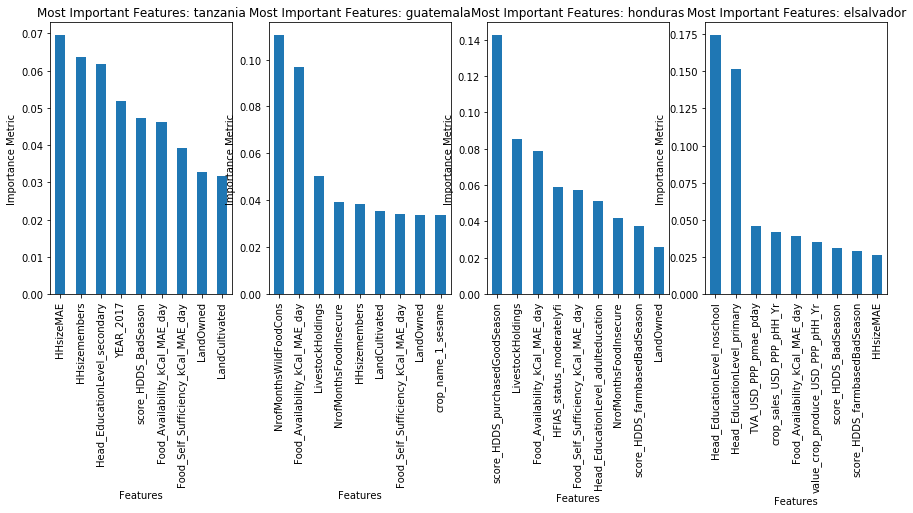

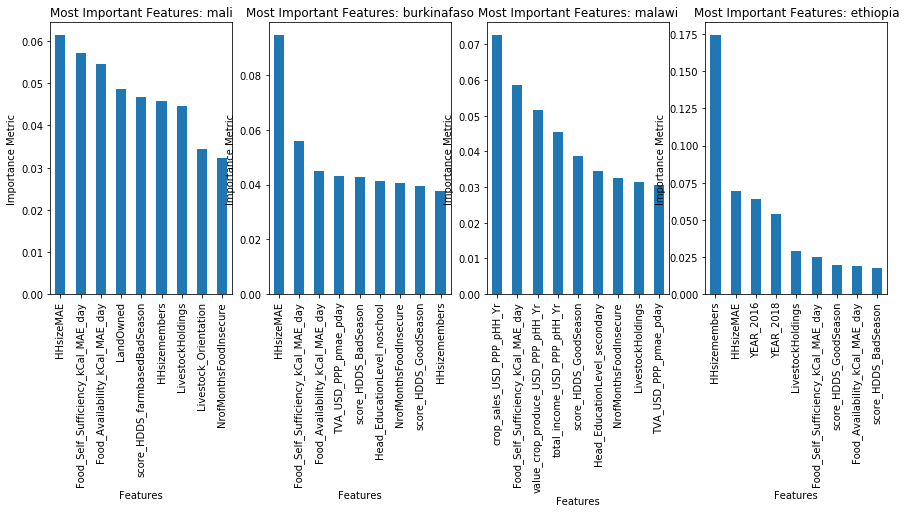

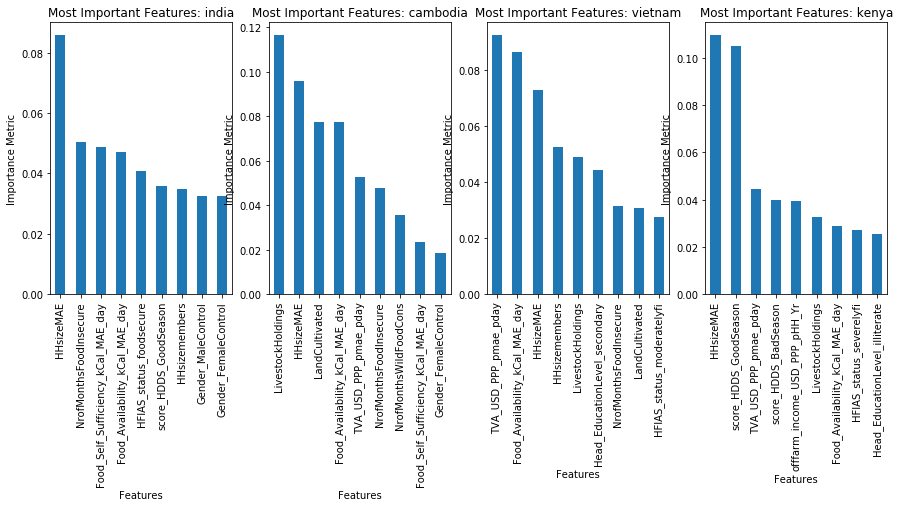

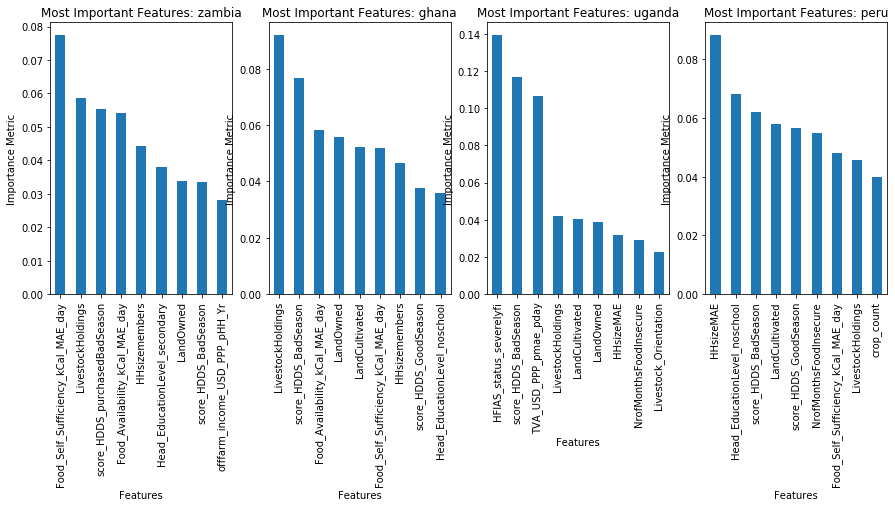

In [112]:
import matplotlib.pyplot as plt
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 5), 
                             sharex=False)
plot_country_feature("tanzania", ax1=ax1)
plot_country_feature("guatemala", ax1=ax2)
plot_country_feature("honduras", ax1=ax3)
plot_country_feature("elsalvador", ax1=ax4)

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 5), 
                             sharex=False)
plot_country_feature("mali", ax1=ax1)
plot_country_feature("burkinafaso", ax1=ax2)
plot_country_feature("malawi", ax1=ax3)
plot_country_feature("ethiopia", ax1=ax4)

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 5), 
                             sharex=False)
plot_country_feature("india", ax1=ax1)
plot_country_feature("cambodia", ax1=ax2)
plot_country_feature("vietnam", ax1=ax3)
plot_country_feature("kenya", ax1=ax4)

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 5), 
                             sharex=False)
plot_country_feature("zambia", ax1=ax1)
plot_country_feature("ghana", ax1=ax2)
plot_country_feature("uganda", ax1=ax3)
plot_country_feature("peru", ax1=ax4)

# By Continent 

In [113]:
clean = pd.read_csv("../data/clean.csv")
clean  = clean.drop("Country", axis =1)
clean.YEAR = clean.YEAR.astype('category')

PPI_data = fun.delete_id_columns(clean) #1
PPI_data, pred_PPI = fun.drop_response_rows_with_NAs(PPI_data, "PPI_Likelihood", "Market_Orientation") #2
PPI_data = fun.replace_NAN_with_na(PPI_data) #3
PPI_data = fun.entry_to_lowercase(PPI_data) #4
PPI_data = fun.remove_underscores_spaces(PPI_data) #5
PPI_data = fun.convert_to_categorical(PPI_data) #6
PPI_data = fun.impute_data(PPI_data)
PPI_data = standarize_data(PPI_data)


X, y = get_dummyXs_y(PPI_data, "PPI_Likelihood")
X_tr, X_te, y_tr, y_te = model_selection.train_test_split(X,y, test_size = 0.3, random_state = 50)

test_mse_ppi = []


In [ ]:
pred_PPI

In [114]:
#produces a dictionary of country specific dataframes
continent_dict={}
for continent in PPI_data["continent"].values.unique():
    new_df = PPI_data[PPI_data["continent"].values  == continent]
    continent_dict[continent] = new_df

In [115]:
def continent_model(continent, y, clf, parameter_dict):
    """
    INPUT
    continent: str, continent name as appears in dataframe
    y: str, column name of response
    clf: scikitlearn clf, the scikit learn model to train 
    parameter_dict: dict, dictionary of model parameters
    
    OUTPUT
    continent: str, continent name as appears in dataframe
    clf: trained best model
    mse: test mse for this model
    index: the list of dummy varaible columns for that country
    """
    X,y = get_dummyXs_y(continent_dict[continent], y)
    X_tr,X_te,y_tr,y_te = model_selection.train_test_split(X,y, test_size=0.3, random_state=50)
    
    index = X.columns
    fit_predict(clf, X_tr,X_te,y_tr,y_te)
    
    best_clf = tune_parameters(X_tr, y_tr, clf, parameter_dict)
    
    best_pred = best_clf.predict(X_te)
    mse = metrics.mean_squared_error(y_te, best_pred)
    print(best_clf.feature_importances_.sort())
    print("\n \n {} \n Test MSE: {}".format(continent, mse))
    
    return continent, best_clf.feature_importances_, mse, index

In [116]:
forest_model = ensemble.RandomForestRegressor()
parameters= {'n_estimators':(np.arange(100, 300, 50)), 'max_depth': [10,20, 50]}

#
#name, ghana_forrest, ghana_mse, index = country_model(country_dict["ghana"], "PPI_Likelihood",forest_model,parameters)
#for key in country_dict:


continent_results= {}
for continent in PPI_data["continent"].values.unique():
    continent_results[continent] =continent_model(continent,
                          "PPI_Likelihood",
                          forest_model,
                          parameters)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  4.7min finished


Best Parameters: {'max_depth': 20, 'n_estimators': 250} 
 Training MSE: -0.5016972585497215 
 Parameter Index: 7
None

 
 africa 
 Test MSE: 0.49516494026632574
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    8.6s finished


Best Parameters: {'max_depth': 20, 'n_estimators': 150} 
 Training MSE: -0.2969700099461836 
 Parameter Index: 5
None

 
 centralamerica 
 Test MSE: 0.2059602804908954
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   25.3s finished


Best Parameters: {'max_depth': 20, 'n_estimators': 150} 
 Training MSE: -0.28618068983392275 
 Parameter Index: 5
None

 
 asia 
 Test MSE: 0.3032671904116702
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    8.0s finished


Best Parameters: {'max_depth': 50, 'n_estimators': 100} 
 Training MSE: -0.007067339914002142 
 Parameter Index: 8
None

 
 southamerica 
 Test MSE: 0.013437622475703192


In [117]:
continent_feature = {}
for continent in continent_results:
    continent_feature[continent] = pd.Series(continent_results[continent][1], 
                                      index=continent_results[continent][3].values).sort_values(ascending=False)


In [118]:
def plot_continent_feature(continent, ax1):
    continent_feature[continent][1:10].plot(kind="bar", 
                                   title = "Most Important Features: {}".format(continent), 
                                   ylabel = "Importance Metric",
                                   xlabel = "Features",
                                            ax=ax1)
    
        


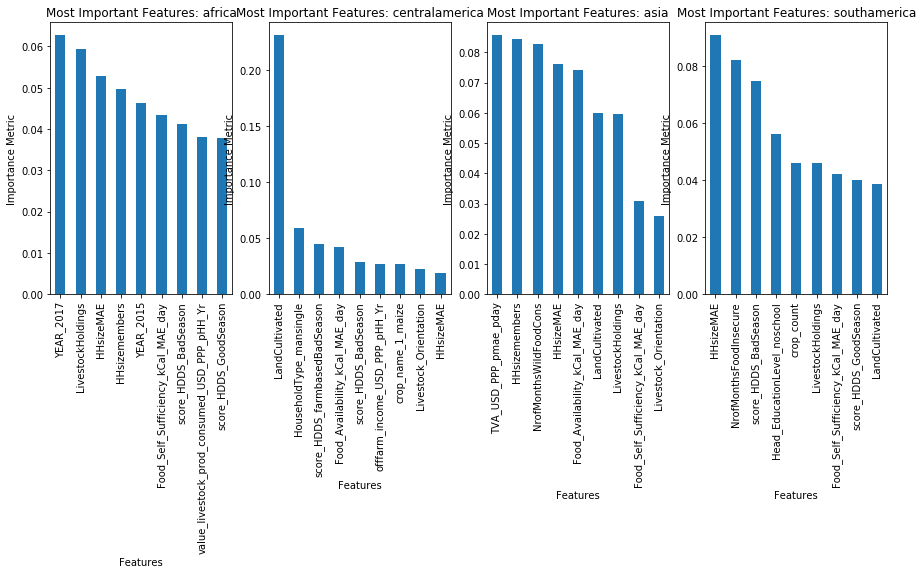

In [119]:
import matplotlib.pyplot as plt
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 5), 
                             sharex=False)
plot_continent_feature("africa", ax1=ax1)
plot_continent_feature("centralamerica", ax1=ax2)
plot_continent_feature("asia", ax1=ax3)
plot_continent_feature("southamerica", ax1=ax4)

